# MarlimR3D - Meshes and Fields

In [1]:
import emg3d
import discretize
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
%matplotlib notebook

## Load survey info

In [3]:
data = xr.load_dataset('marlim_survey.nc', engine='h5netcdf')

## Load results from modellers

### Tensor Mesh: emg3d

In [4]:
egd = emg3d.load('results/emg3d_meshesfields.h5')
mesh_emg3d = egd['mesh']
efield_emg3d_fx = egd['fx']
efield_emg3d_fy = egd['fy']

Data loaded from «/home/dtr/Codes/article-os-csem/model-marlim/results/emg3d_meshesfields.h5»
[emg3d v0.12.0 (format 0.12.0) on 2020-09-15T16:18:17.926653].


### OcTree Mesh: SimPEG

In [5]:
# Lindsey from SimPEG

### Tetrahedral Mesh: custEM

In [6]:
# Raphael from custEM, as example (custEM/PETGEM use the same mesh)

## Figures

We create two figures:
- Once the entire mesh; the x-/z-extent will be different for all mesh types, but we should set the xlim/zlim to the max-extent for all meshes on each individual as well, for easy comparison
- Once for the survey zone.

<IPython.core.display.Javascript object>


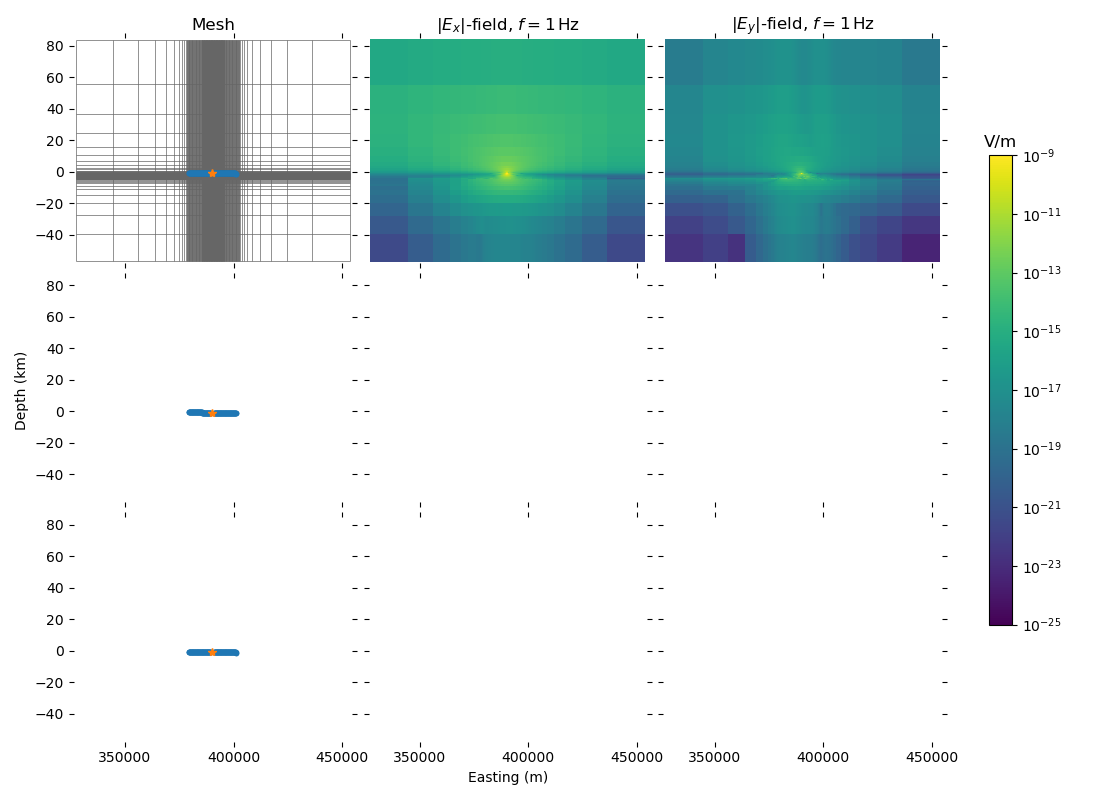

<IPython.core.display.Javascript object>


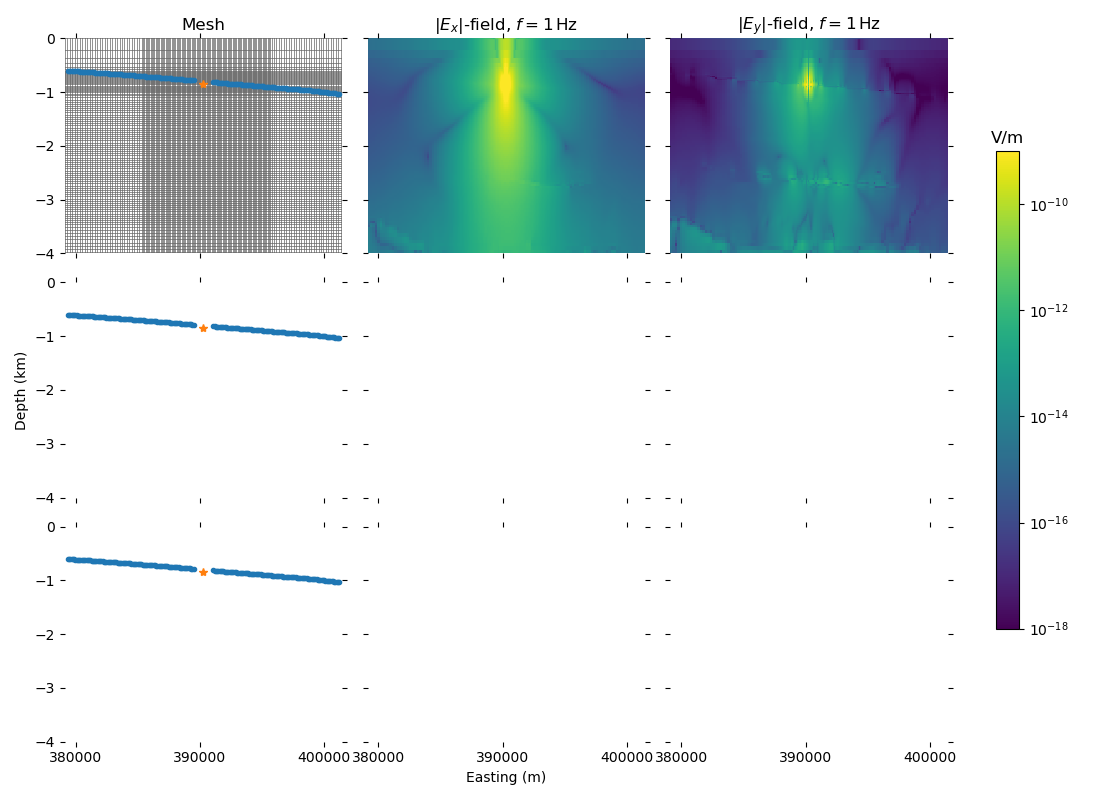

In [7]:
# Define some appearances here, so we can easily change them for all
lc = '0.4'
lw = 0.5

for case in ['entire', 'survey']:

    # Min/max for pcolormesh, depending on case.
    if case == 'entire':
        vmin = 1e-25
        vmax = 1e-9
    else:
        vmin = 1e-18
        vmax = 1e-9

    # Initiate figure (axes shared)
    fig, axs = plt.subplots(3, 3, figsize=(11, 8), sharey=True, sharex=True)
    ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = axs


    # # # (A) TensorMesh (ax1-ax3) # # #
    
    # Get dimension from mesh
    xmin, xmax = mesh_emg3d.vectorNx[0], mesh_emg3d.vectorNx[-1]
    zmin, zmax = mesh_emg3d.vectorNz[0]/1e3, mesh_emg3d.vectorNz[-1]/1e3
    
    # Plot horizontal and vertical lines
    ax1.vlines(mesh_emg3d.vectorNx, zmin, zmax, colors=lc, lw=lw)
    ax1.hlines(mesh_emg3d.vectorNz/1e3, xmin, xmax, colors=lc, lw=lw)

    # Plot Ex-field
    for ax, field in zip([ax2, ax3], [efield_emg3d_fx, efield_emg3d_fy]):
        cb = ax.pcolormesh(mesh_emg3d.vectorNx, mesh_emg3d.vectorNz/1e3,
                           abs(field.T), rasterized=True, 
                           norm=LogNorm(vmin=vmin, vmax=vmax))





    # # # (B) OcTreeMesh (ax4-ax6) # # #

    # Lindsey TODO:
    # Plot here the OcTree-mesh results for the x-z at y=7517812.0 (rec-location)
    #
    # ax4 : Mesh
    # ax5 : Ex-field
    # ax6 : Ey-field





    # # # (C) TetrahedralMesh (ax7-ax9) # # #

    # Raphael TODO:
    # Plot here the Tetrahedral-mesh results for the x-z at y=7517812.0 (rec-location)
    #
    # ax7 : Mesh
    # ax8 : Ex-field
    # ax9 : Ey-field





    # # # FINALIZE # # #
    
    # Plot survey over meshes.
    for ax in axs[:, 0]:
        ax.plot(data.src_x[::2], data.data_il.attrs['src_z']/1e3,
                '.', label=f"Inline; {data.data_il.attrs['lineid']}")
        ax.plot(data.attrs['rec_x'], data.attrs['rec_z']/1e3, '*', label='Receiver')
    
    # Set x- and y-limits
    if case == 'survey':
        ax1.set_xlim([data.src_x[0]-250, data.src_x[-1]+250])
        ax1.set_ylim([-4, 0])
    else:  # => TODO: ADJUST to min/max of all meshes!!!
        ax1.set_xlim([xmin-1000, xmax+1000])
        ax1.set_ylim([zmin-1, zmax+1])
        
    # Titles and labels.
    ax1.set_title('Mesh')
    ax2.set_title('$|E_x|$-field, $f=1\,$Hz')
    ax3.set_title('$|E_y|$-field, $f=1\,$Hz')
    ax8.set_xlabel('Easting (m)')
    ax4.set_ylabel('Depth (km)')

    # Turn spines off, but ticks on all sides.
    for ax in axs.ravel():
        [ax.spines[k].set_visible(False) for k in ax.spines.keys()]
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
    
    # Reduce number of ticks.
    if case == 'survey':
        ax1.set_yticks([-4, -3, -2, -1, 0])
    ax1.set_xticks(ax1.xaxis.get_ticklocs()[1::2])

    # Make tight, leave space for colorbar.
    fig.tight_layout(w_pad=0.01, rect=[0, 0, 0.95, 1])

    # Colorbar.
    c = fig.colorbar(cb, ax=axs, fraction=0.025)
    c.ax.set_title('V/m')

    # Save and show.
    fig.savefig(f'../manuscript/figures/results-marlim_{case}.pdf', bbox_inches='tight')
    fig.show()

In [8]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Tue Sep 15 16:36:46 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49)
  [GCC 7.5.0]

             numpy : 1.19.1
             scipy : 1.5.2
             numba : 0.51.2
             emg3d : 0.12.0
           empymod : 2.0.2
            xarray : 0.16.0
        discretize : 0.5.0
              h5py : 2.10.0
        matplotlib : 3.3.1
           IPython : 7.18.1
--------------------------------------------------------------------------------